Procesando raw_data_99_75.csv...
Frecuencia Cardíaca Estimada: 73.08 BPM


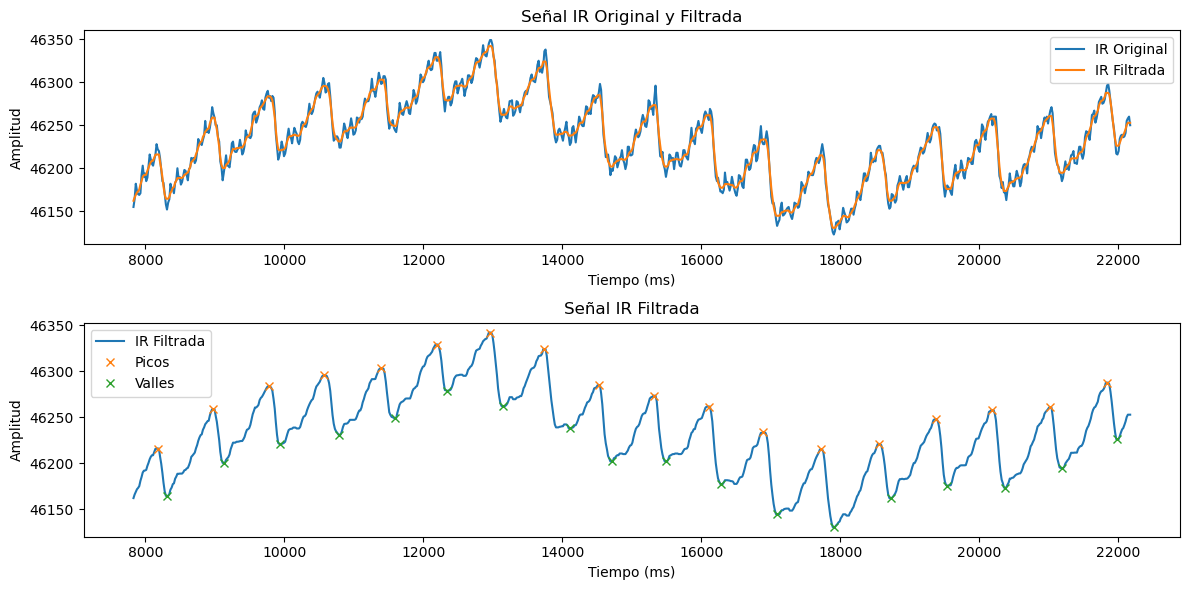

Procesando raw_data_95_77_2.csv...
Frecuencia Cardíaca Estimada: 82.99 BPM


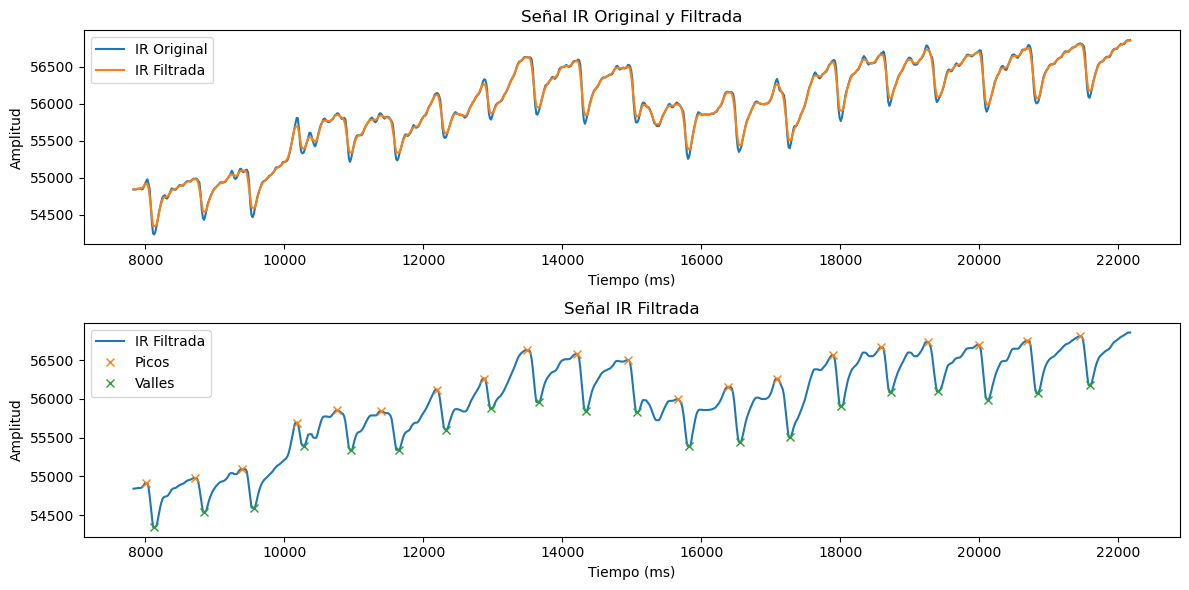

Procesando raw_data_95_99.csv...
Frecuencia Cardíaca Estimada: 92.76 BPM


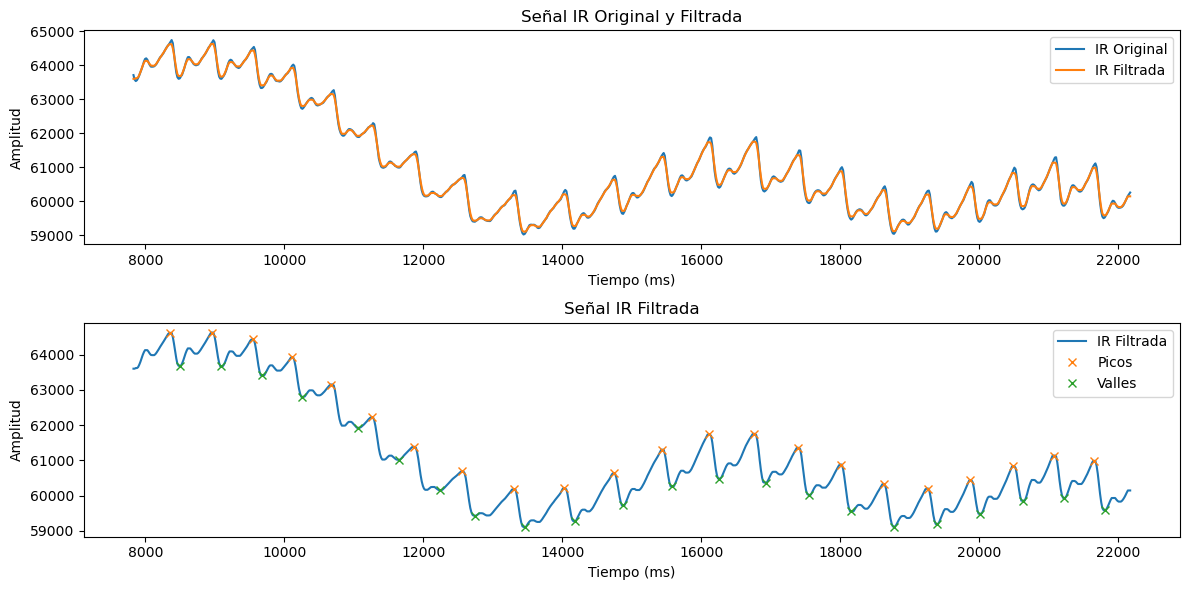

Procesando raw_data_98_81.csv...
Frecuencia Cardíaca Estimada: 78.82 BPM


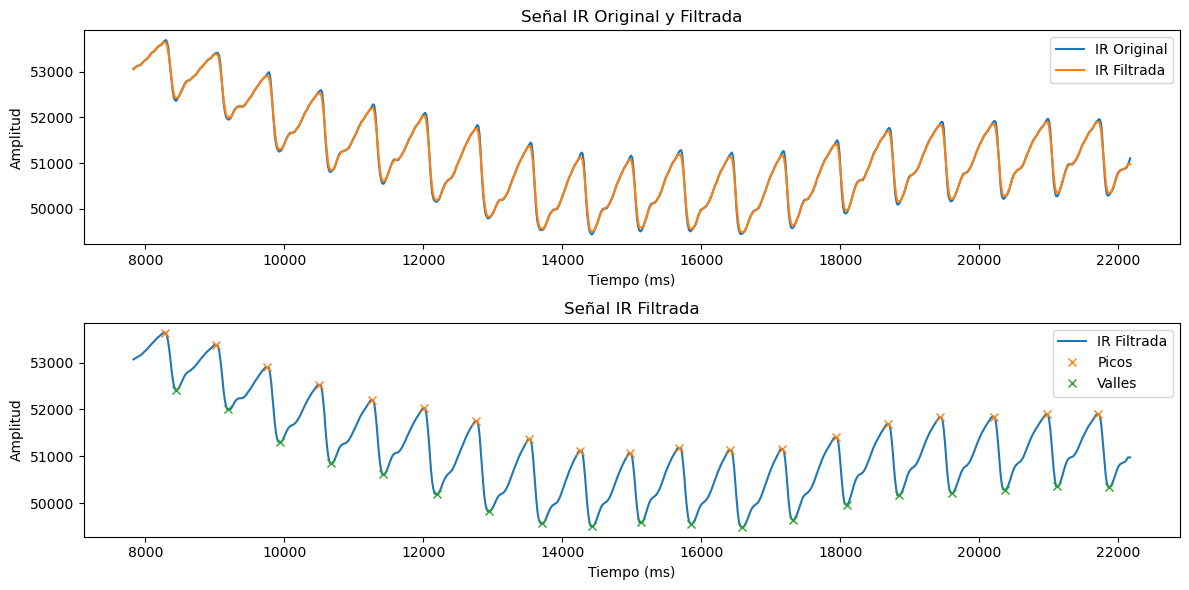

Procesando raw_data_96_69.csv...
Frecuencia Cardíaca Estimada: 69.72 BPM


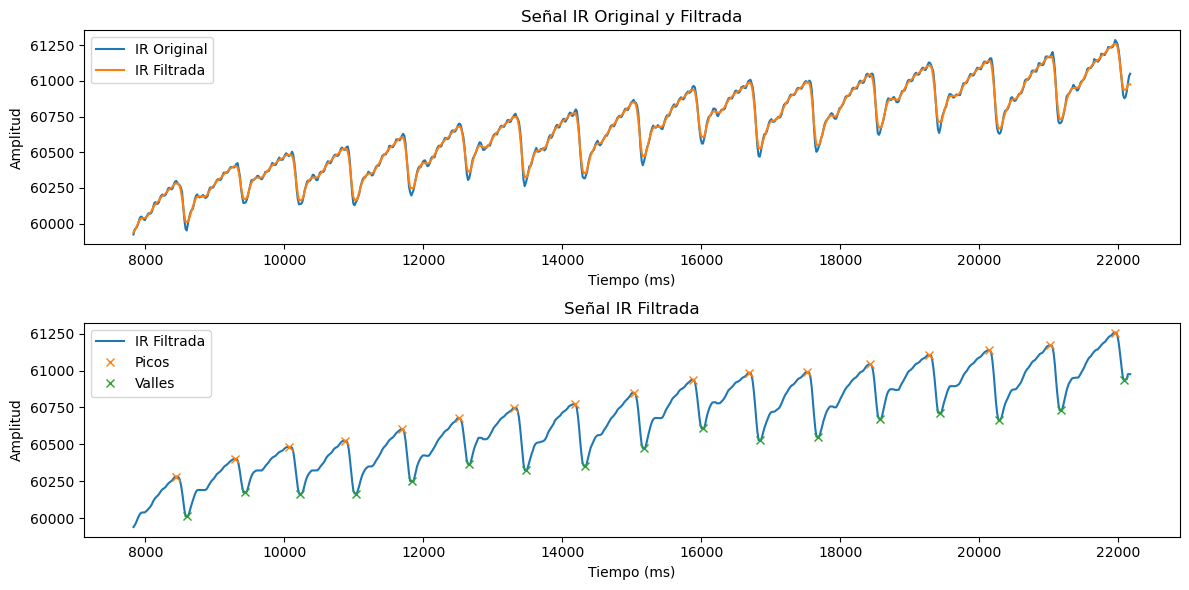

Procesando raw_data_96_106.csv...
Frecuencia Cardíaca Estimada: 86.51 BPM


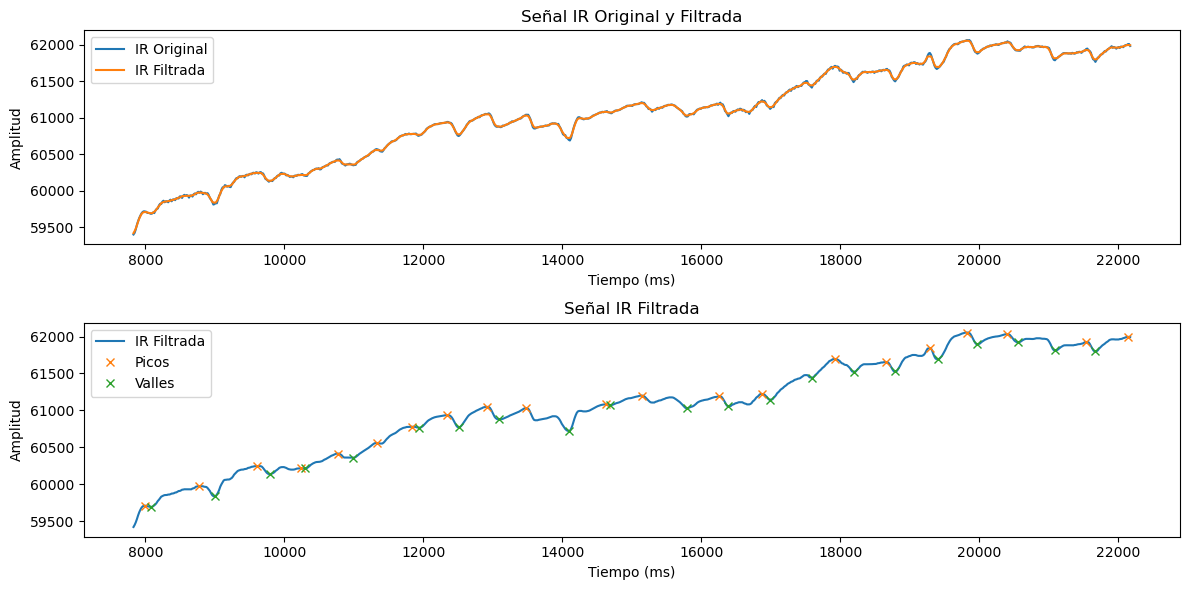

Procesando raw_data_98_86.csv...
Frecuencia Cardíaca Estimada: 85.32 BPM


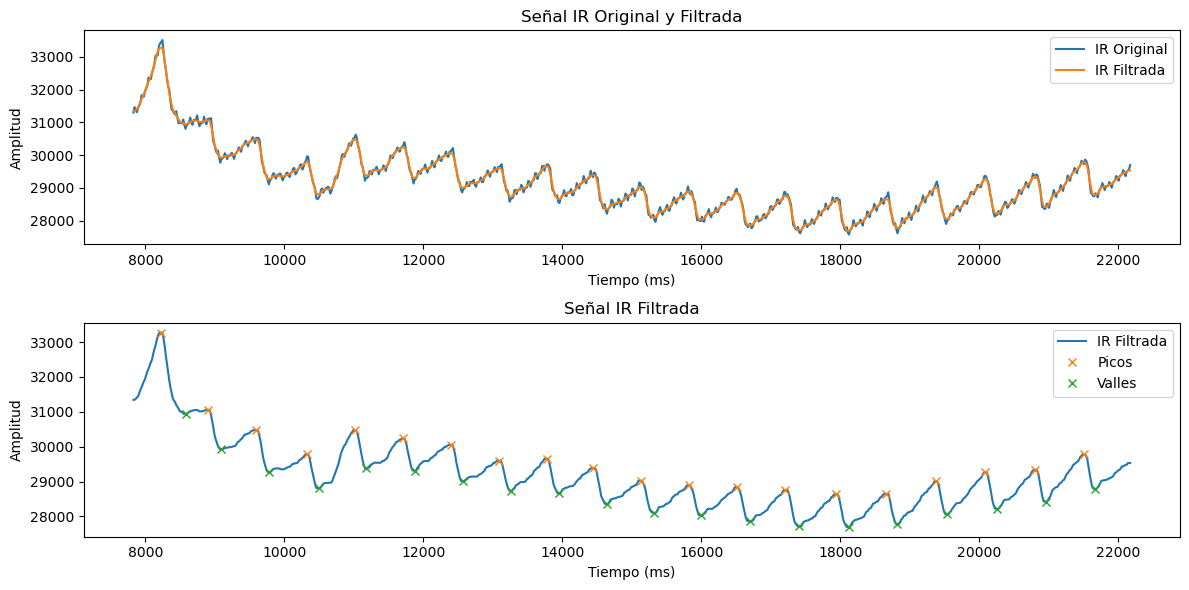

Procesando raw_data_98_91.csv...
Frecuencia Cardíaca Estimada: 100.84 BPM


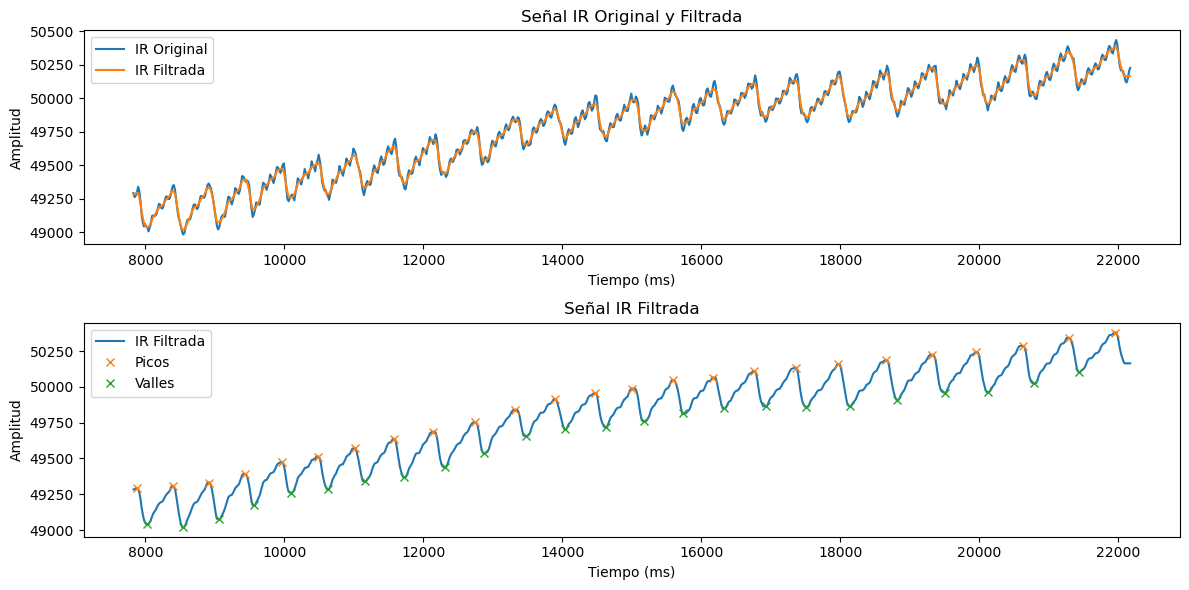

Procesando raw_data_97_119.csv...
Frecuencia Cardíaca Estimada: 87.91 BPM


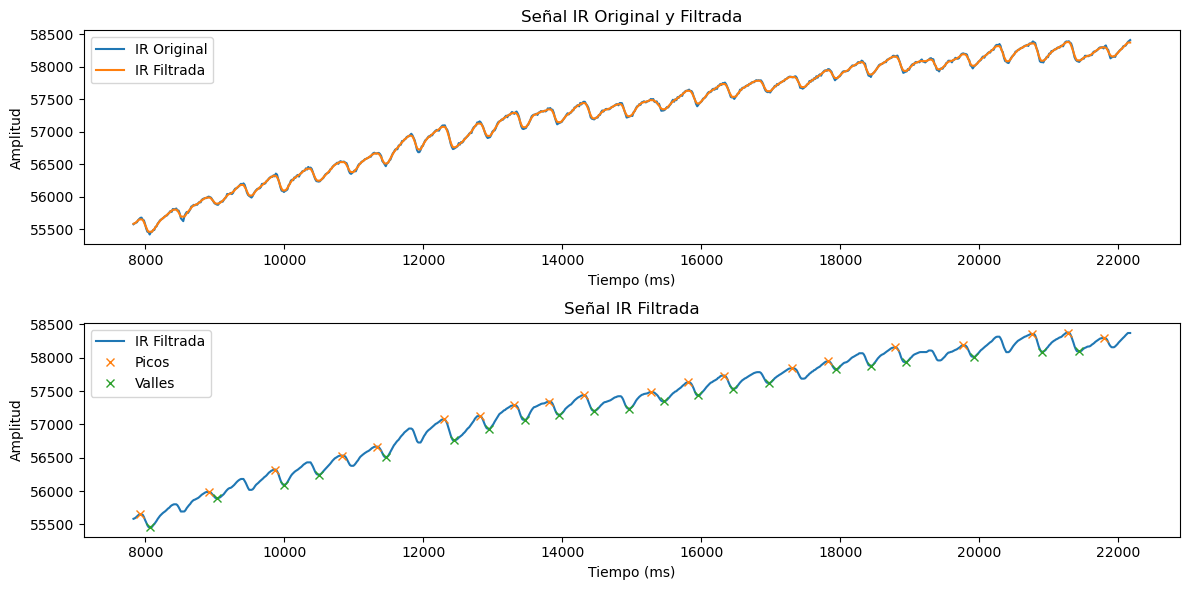

Procesando raw_data_91_91.csv...
Frecuencia Cardíaca Estimada: 90.72 BPM


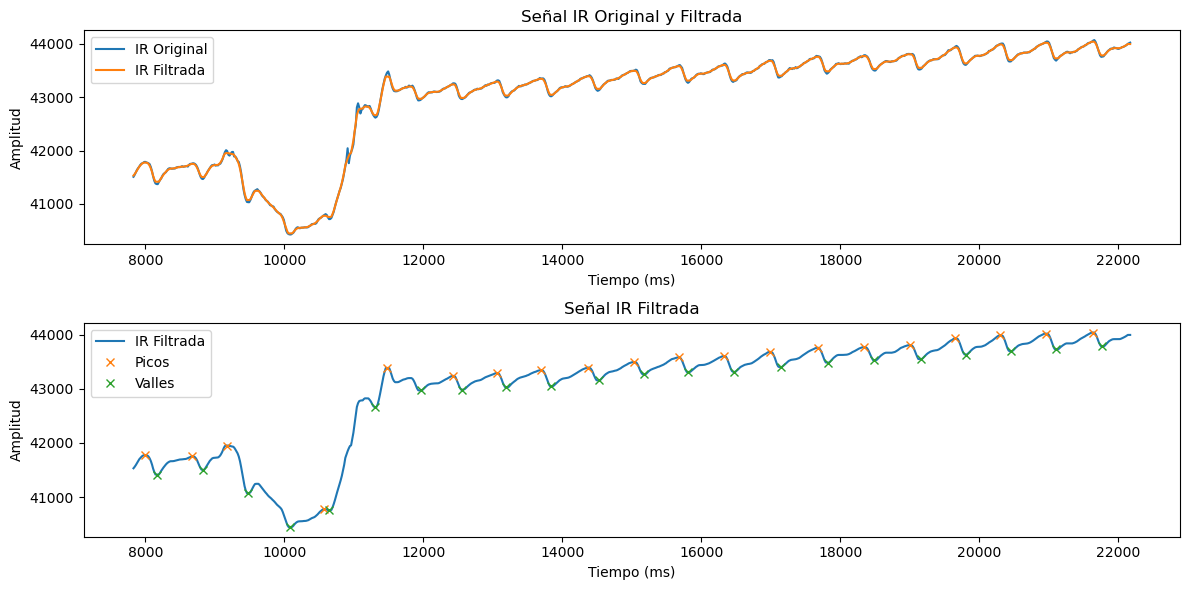

Procesando raw_data_93_100.csv...
Frecuencia Cardíaca Estimada: 90.28 BPM


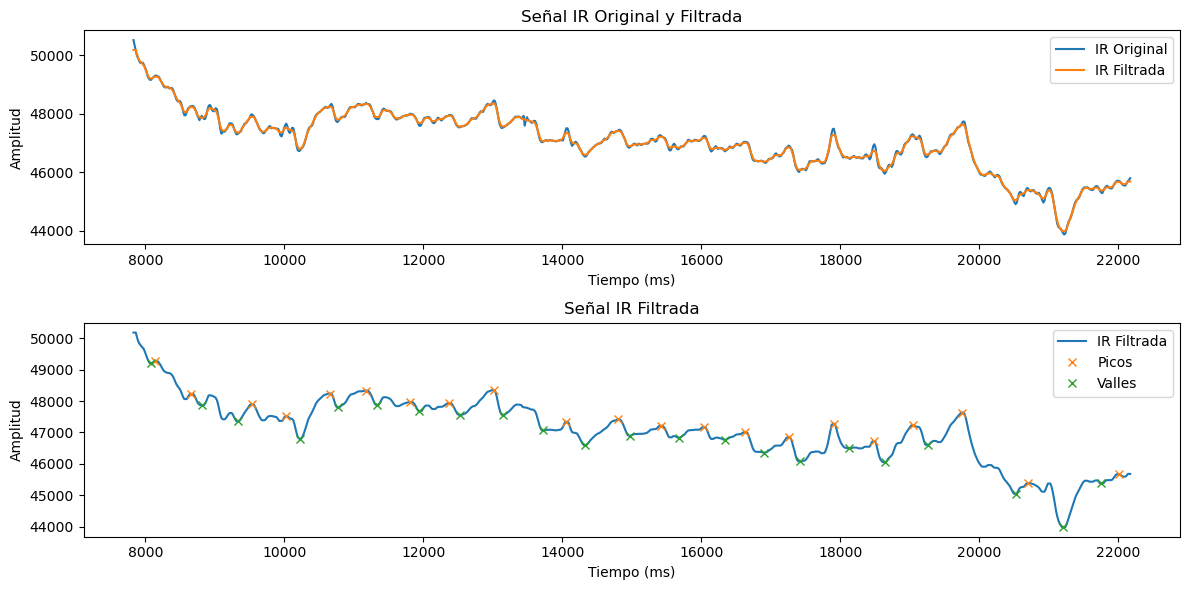

Procesando raw_data_95_80.csv...
Frecuencia Cardíaca Estimada: 75.54 BPM


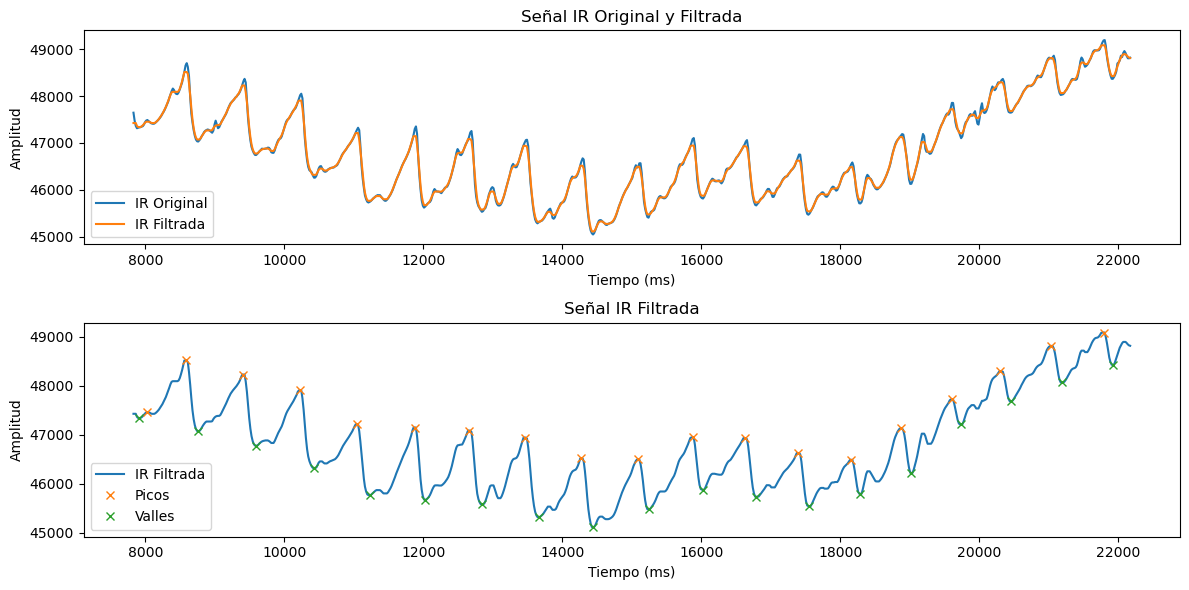

Procesando raw_data_92_76.csv...
Frecuencia Cardíaca Estimada: 82.48 BPM


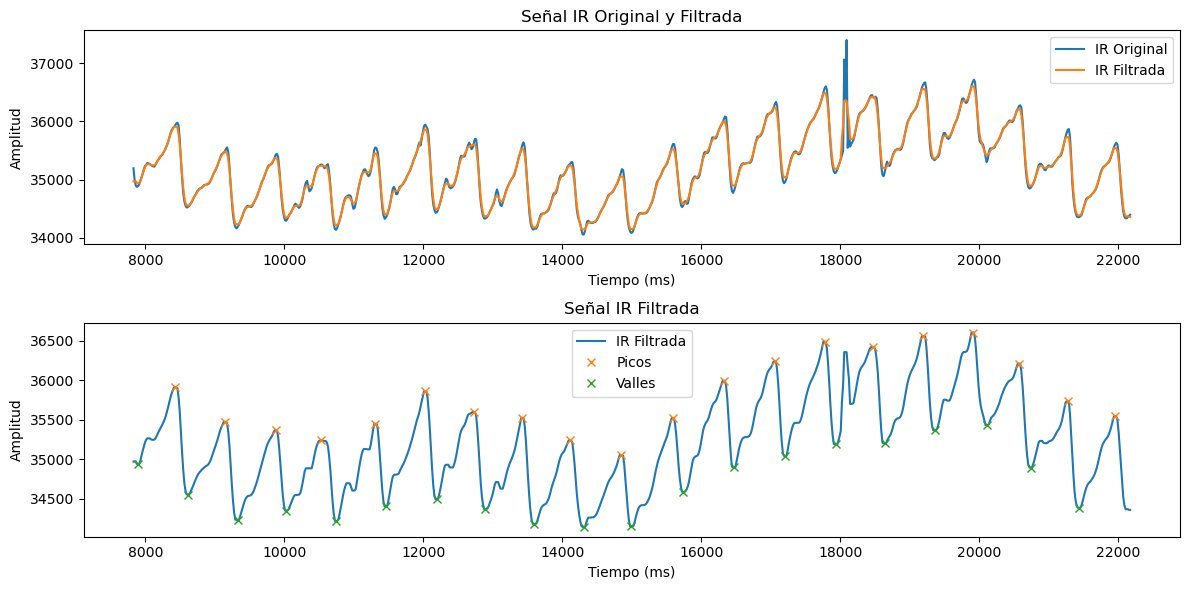

Procesando raw_data_99_91.csv...
Frecuencia Cardíaca Estimada: 76.84 BPM


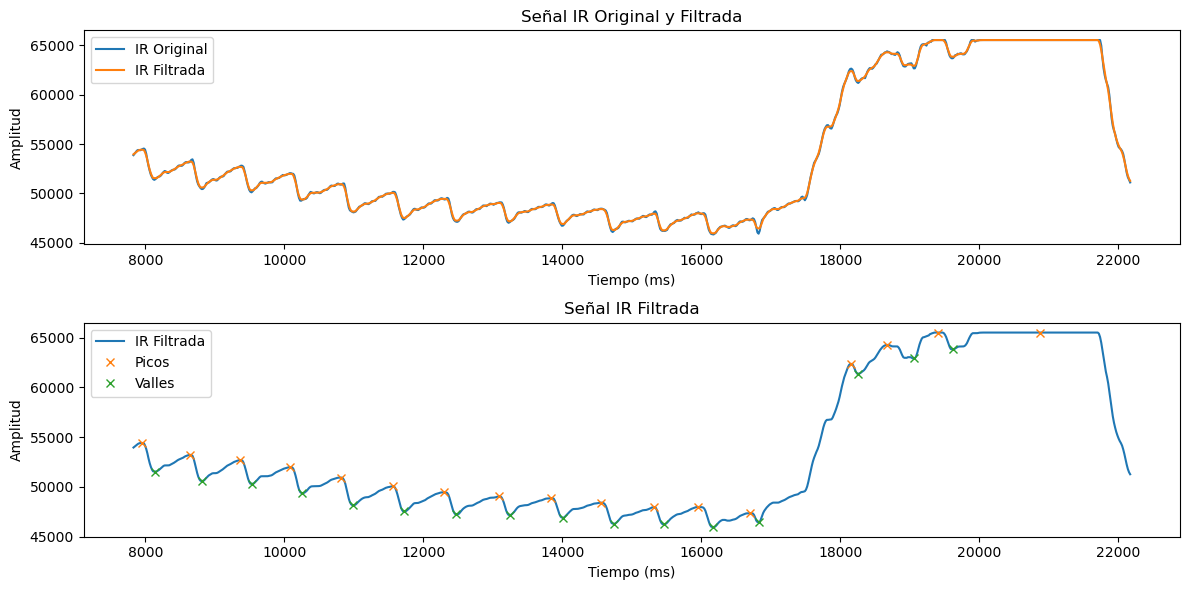

Procesando raw_data_97_95.csv...
Frecuencia Cardíaca Estimada: 93.64 BPM


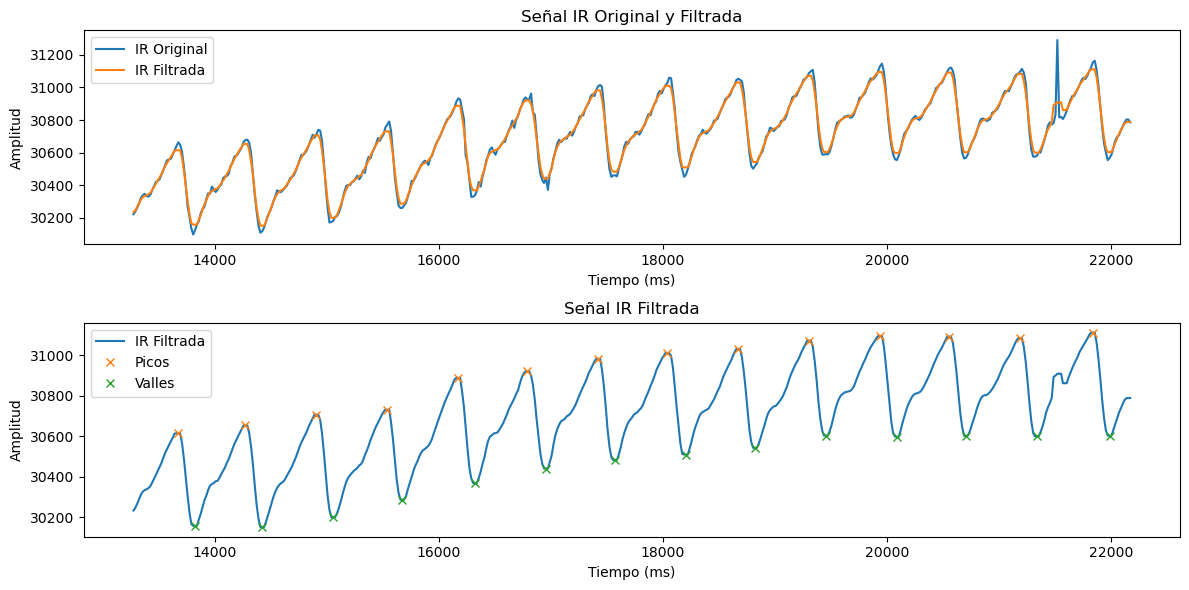

Procesando raw_data_95_81_papa.csv...
Frecuencia Cardíaca Estimada: 78.43 BPM


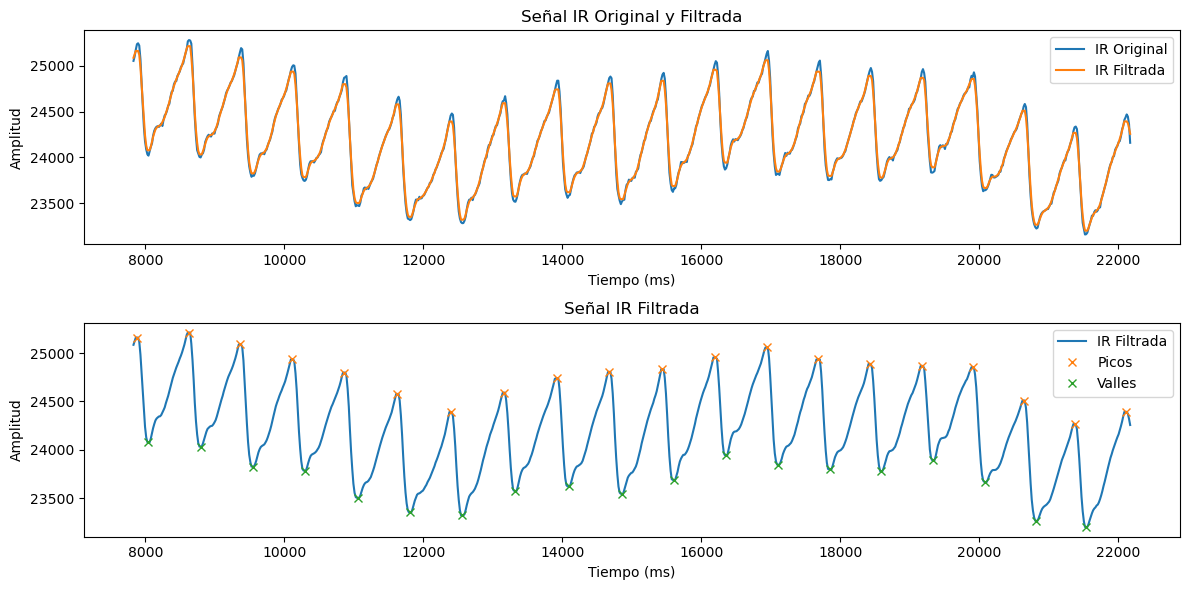

In [7]:
import pandas as pd
import numpy as np
import scipy.signal as signal
from matplotlib import pyplot as plt

# Cargar datos
def load_data(filename):
    df = pd.read_csv(filename, delimiter=';', decimal=',')
    df.columns = ['Tiempo_ms', 'IR', 'AMB_IR', 'RED', 'AMB_RED']
    return df

# Eliminar primeros y últimos segundos
def trim_data(df, seconds_to_trim=2):
    fs = estimate_sampling_rate(df)  # Estimar frecuencia de muestreo
    samples_to_trim = int(seconds_to_trim * fs)
    return df.iloc[samples_to_trim:-samples_to_trim].reset_index(drop=True)

# Estimar frecuencia de muestreo
def estimate_sampling_rate(df):
    time_diffs = np.diff(df["Tiempo_ms"]) / 1000  # Convertir ms a s
    return 1 / np.median(time_diffs)

# Aplicar filtro de media móvil con padding
def moving_average_filter(signal, window_size=6):
    pad_size = window_size // 2
    padded_signal = np.pad(signal, (pad_size, pad_size), mode='edge')  # Relleno con los bordes
    filtered_signal = np.convolve(padded_signal, np.ones(window_size)/window_size, mode='valid')

    return filtered_signal

# Calcular frecuencia cardíaca (HR)
def calculate_heart_rate(ir_signal, sampling_rate):
    peaks, _ = signal.find_peaks(ir_signal, distance=sampling_rate*0.5)  # Mínimo 0.5s entre latidos
    peak_intervals = np.diff(peaks) / sampling_rate  # Intervalos entre picos en segundos
    
    inverted_singal = -1 * ir_signal
    valleys, _ = signal.find_peaks(inverted_singal, distance=sampling_rate*0.5)  # Mínimo 0.5s entre latidos
    valley_intervals = np.diff(valleys) / sampling_rate  # Intervalos entre picos en segundos
    
    if len(valley_intervals) > 0 or len(peak_intervals) > 0:
        heart_rate = 60 / np.mean(valley_intervals)
        #heart_rate = 60 / np.mean(peak_intervals)  # BPM
    else:
        heart_rate = np.nan
    return heart_rate, peaks, valleys
 

def calculate_and_graph(filename):
    data = load_data(filename)
    data = trim_data(data, seconds_to_trim=8)
    data["IR_filtered"] = moving_average_filter(data["IR"], window_size=5)
    data["IR_filtered"] = signal.medfilt(data["IR_filtered"], kernel_size=5)  # Filtro de mediana

    # Estimar HR
    fs = estimate_sampling_rate(data)
    #print(f"Frecuencia de muestreo estimada: {fs:.2f} Hz")

    # Calcular frecuencia cardíaca
    heart_rate, peaks, valleys = calculate_heart_rate(data["IR_filtered"], fs)

    #Calculo de la frecuencia cardiaca con FFT


    # Resultados
    print(f"Frecuencia Cardíaca Estimada: {heart_rate:.2f} BPM")

    # Graficar las señal R original y la filtrada con los picos
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(data["Tiempo_ms"], data["IR"], label='IR Original')
    plt.plot(data["Tiempo_ms"], data["IR_filtered"], label='IR Filtrada')
    plt.title('Señal IR Original y Filtrada')
    plt.xlabel('Tiempo (ms)')
    plt.ylabel('Amplitud')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(data["Tiempo_ms"], data["IR_filtered"], label='IR Filtrada')
    plt.plot(data["Tiempo_ms"].iloc[peaks], data["IR_filtered"].iloc[peaks], "x", label='Picos')
    plt.plot(data["Tiempo_ms"].iloc[valleys], data["IR_filtered"].iloc[valleys], "x", label='Valles')
    plt.title('Señal IR Filtrada')  
    plt.xlabel('Tiempo (ms)')
    plt.ylabel('Amplitud')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ejecutar la funcion para todos los archivos en un directorio dadp
import os
directory = 'Datos/Datos crudos/save_log2'
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        print(f"Procesando {filename}...")
        calculate_and_graph(file_path)
    else:
        continue


# Diagrama de bloques

Datos RAW (IR) \
   ↓\
Recorte de inicio/fin\
   ↓\
Filtro media móvil\
   ↓\
Filtro mediana\
   ↓\
Detección de picos/valles\
   ↓\
Cálculo Frecuencia Cardíaca (HR)\
   ↓\
Visualización / Resultado
